# Image Classification :-

### In this project, I have classified images from the CIFAR-10 dataset(https://www.cs.toronto.edu/~kriz/cifar.html). The dataset consists of airplanes, dogs, cats, and other objects. I have preprocess the images, then train a convolutional neural network on all the samples.The images need to be normalized and the labels need to be one-hot encoded. 

# Get the data :-

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

In [5]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

# Explore the data :-


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 6:
Image - Min Value: 7 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


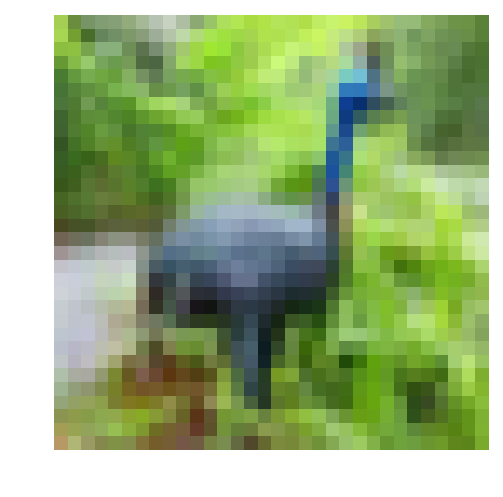

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 6
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Normalize :-

In [24]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return x / 255

## One-hot encode :- 

In [25]:
from keras.utils import np_utils
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    return np_utils.to_categorical(x)

Using TensorFlow backend.


## Preprocessing all the data and saving it :-

In [26]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Check Point :-

In [28]:
import pickle
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Building the network :-

In [29]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    shape = [None] + list(image_shape)
    return tf.placeholder(tf.float32, shape = shape, name = "x")

def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape = [None,n_classes], name = "y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, name = "keep_prob")

In [30]:
def new_weights(shape):
    # Create new weights for each layer
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    
def new_biases(length):
    # Create new biases for each layer
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Convolution and Max Pooling Layer :-

In [31]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    
    # Number of input units to a layer
    conv_num_inputs = x_tensor.get_shape().as_list()[3]
    
    conv_height = conv_ksize[0]
    conv_width = conv_ksize[1]
    
    conv_shape = [conv_height, conv_width, conv_num_inputs, conv_num_outputs]
    
    # Update the weights before building the convolutional neural network
    weights = new_weights(shape = conv_shape)
    
    x_tensor = tf.nn.conv2d(input = x_tensor,
                            filter = weights,
                            strides = [1, conv_strides[0], conv_strides[1], 1],
                            padding = 'SAME')
    
    # Update the biases before applying them
    biases = new_biases(length = conv_num_outputs)
    x_tensor += biases
    
    # Apply the activation function
    x_tensor = tf.nn.elu(x_tensor)
    
    x_tensor = tf.nn.max_pool(value = x_tensor,
                               ksize=[1, conv_height, conv_width, 1],
                               strides=[1, pool_strides[0], pool_strides[1], 1],
                               padding='SAME')
    
    return x_tensor 

### Flatten Layer :-

In [32]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    
    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]
    layer_shape = x_tensor.get_shape()
    
    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    x_tensor = tf.reshape(x_tensor, [-1, num_features])
    
    return x_tensor

### Fully-Connected Layer :-

In [33]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    num_inputs = x_tensor.get_shape().as_list()[1]
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    layer = tf.add(tf.matmul(x_tensor, weights), biases)

    layer = tf.nn.elu(layer)
    
    return layer

### Output Layer :-

In [34]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    
    num_inputs = x_tensor.get_shape().as_list()[1]
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    layer = tf.add(tf.matmul(x_tensor, weights), biases)
    
    return layer

### Convolutional Model :-

In [42]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    # Layer 1
    x1 = conv2d_maxpool(x_tensor = x, 
                   conv_num_outputs = 32, 
                   conv_ksize = (5,5), 
                   conv_strides = (2,2), 
                   pool_ksize = (2,2), 
                   pool_strides = (1,1))
    
    x1 = tf.nn.dropout(x1, keep_prob)
    
    # Layer 2
    x2 = conv2d_maxpool(x_tensor = x1, 
                   conv_num_outputs = 64, 
                   conv_ksize = (5,5), 
                   conv_strides = (1,1), 
                   pool_ksize = (2,2), 
                   pool_strides = (1,1))
    
    x2 = tf.nn.dropout(x2, keep_prob)
    
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    
    x2 = flatten(x_tensor = x2)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    
    x2 = fully_conn(x_tensor = x2,
               num_outputs = 128)
    x2 = fully_conn(x_tensor = x2,
               num_outputs = 256)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    
    x2 = output(x_tensor = x2,
               num_outputs = 10)
    
    # TODO: return output
    return x2

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Training the Neural Network :-

In [43]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    
    session.run(optimizer, feed_dict = {x: feature_batch,
                                        y: label_batch,
                                        keep_prob: keep_probability})

### Show Stats :-

In [44]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    cost_score, accuracy_score = session.run([cost, accuracy], feed_dict = {x: valid_features,
                                                                            y: valid_labels,
                                                                            keep_prob: 1})
    
    print("cost_score = {0:>6.4}, accuracy_score = {1:>3.4%}".format(cost_score, accuracy_score))

### Hyperparameters :-

In [45]:
# TODO: Tune Parameters
epochs = 20
batch_size = 128
keep_probability = 0.7

### Training on a Single CIFAR-10 Batch :-

In [46]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  cost_score =  1.929, accuracy_score = 35.3800%
Epoch  2, CIFAR-10 Batch 1:  cost_score =  1.561, accuracy_score = 44.4800%
Epoch  3, CIFAR-10 Batch 1:  cost_score =  1.398, accuracy_score = 49.7000%
Epoch  4, CIFAR-10 Batch 1:  cost_score =  1.407, accuracy_score = 50.2800%
Epoch  5, CIFAR-10 Batch 1:  cost_score =  1.352, accuracy_score = 52.5800%
Epoch  6, CIFAR-10 Batch 1:  cost_score =  1.394, accuracy_score = 52.8800%
Epoch  7, CIFAR-10 Batch 1:  cost_score =   1.38, accuracy_score = 54.4800%
Epoch  8, CIFAR-10 Batch 1:  cost_score =  1.304, accuracy_score = 57.3000%
Epoch  9, CIFAR-10 Batch 1:  cost_score =  1.425, accuracy_score = 54.1200%
Epoch 10, CIFAR-10 Batch 1:  cost_score =  1.488, accuracy_score = 54.4200%
Epoch 11, CIFAR-10 Batch 1:  cost_score =  1.525, accuracy_score = 54.9400%
Epoch 12, CIFAR-10 Batch 1:  cost_score =  1.593, accuracy_score = 54.8400%
Epoch 13, CIFAR-10 Batch 1:  cost_score =  1.

### Fully Training the Model :-

In [47]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  cost_score =  2.544, accuracy_score = 25.4600%
Epoch  1, CIFAR-10 Batch 2:  cost_score =  1.795, accuracy_score = 37.9000%
Epoch  1, CIFAR-10 Batch 3:  cost_score =  1.732, accuracy_score = 41.1200%
Epoch  1, CIFAR-10 Batch 4:  cost_score =   1.68, accuracy_score = 41.3400%
Epoch  1, CIFAR-10 Batch 5:  cost_score =  1.262, accuracy_score = 54.8000%
Epoch  2, CIFAR-10 Batch 1:  cost_score =  1.272, accuracy_score = 55.7600%
Epoch  2, CIFAR-10 Batch 2:  cost_score =  1.235, accuracy_score = 56.3400%
Epoch  2, CIFAR-10 Batch 3:  cost_score =  1.149, accuracy_score = 58.9400%
Epoch  2, CIFAR-10 Batch 4:  cost_score =  1.161, accuracy_score = 59.2000%
Epoch  2, CIFAR-10 Batch 5:  cost_score =  1.112, accuracy_score = 61.2000%
Epoch  3, CIFAR-10 Batch 1:  cost_score =  1.109, accuracy_score = 61.6400%
Epoch  3, CIFAR-10 Batch 2:  cost_score =  1.144, accuracy_score = 58.5400%
Epoch  3, CIFAR-10 Batch 3:  cost_score =   1.03, accuracy_score = 63.2600%


### Test Model :-

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6887856012658228



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


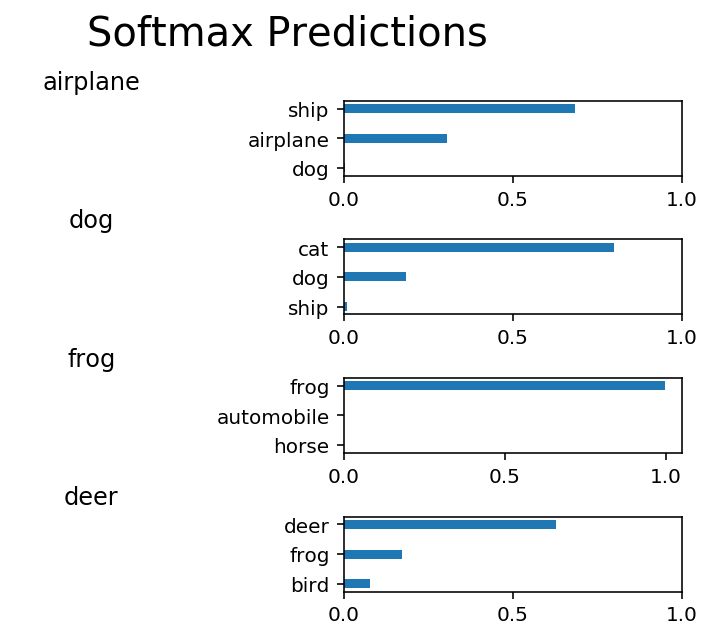

In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()